In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import datasets
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import h5py
%matplotlib inline

In [4]:
from PIL import Image

In [5]:
data_dir = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset'

In [6]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*/*')))
print(image_count)

5866


In [7]:
# Reading both normal and pneumonia files into a single object
train_ds_list = tf.data.Dataset.list_files(str(data_dir) +'/train/*/*', shuffle=True, seed = 0)
val_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/val/*/*', shuffle= True, seed = 0)
test_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/test/*/*', shuffle= True, seed = 0)

In [8]:
class_names = np.array(sorted(list(set([item.name for item in data_dir.glob('*/*') if item.name != "LICENSE.txt"]))))
print(class_names)

['NORMAL' 'PNEUMONIA']


In [9]:
img_height = 256
img_width = 256
batch_size = 32

In [10]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  #return tf.argmax(one_hot)
  return one_hot

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

# def label_path(file_path):
#   label = get_label(file_path)
#   return label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)

# train_class = train_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# val_class = val_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# test_class = test_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)

In [11]:
rNr = tf.keras.Sequential([layers.Rescaling(1./255)]) #Rescaling

In [12]:
from keras.models import load_model
stage1 = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best.hdf5", compile=False)

In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Subtract, Add, Rescaling
from keras.models import Model

In [14]:
pre_input = Input(shape=(img_height,img_width,1), name="pre_input")

rescale = Rescaling(1./255)(pre_input)
stage1.trainable = False
reconstructed1 = stage1(rescale)
sub = Subtract()([rescale, reconstructed1])

m2_preprocess = Model(pre_input, sub, name="preprocess_m2")

In [15]:
def configure_for_performance(ds):
  ds = ds.batch(batch_size)
  ds = ds.map(lambda x : (m2_preprocess(x), m2_preprocess(x)), num_parallel_calls = AUTOTUNE)
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### Model Training

In [ ]:
input_img = Input(shape=(img_height,img_width,1), name="m2_encoder_input")

x = Conv2D(128, (3, 3), (2, 2), activation='relu', padding ='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
encoded_m2 = Dense(256, activation= 'relu')(x)

m2_encoder = Model(input_img, encoded_m2, name="encoder_m2")

m2_encoder.summary()

Model: "encoder_m2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m2_encoder_input (InputLaye  [(None, 256, 256, 1)]    0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                        

In [ ]:
m2_latent = Input(shape=(256), name="m2_decoder_input")
#input_img = Input(shape=(img_height,img_width,1), name="m2_img")

x = BatchNormalization()(m2_latent)
x = Dense(1024, activation='relu')(x)
x = Reshape((32,32,1))(x)

x = Conv2D(32, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding ='same')(x)

m2_decoder = Model(m2_latent, decoded, name="decoder_m2")


m2_decoder.summary()

Model: "decoder_m2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m2_decoder_input (InputLaye  [(None, 256)]            0         
 r)                                                              
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 32)       0

In [ ]:
# Autoencoder 2

ae_input = Input(shape=(img_height,img_width,1), name="m2_input_all")

ae_encoder_output = m2_encoder(ae_input)
ae_decoder_output = m2_decoder(ae_encoder_output)

m2 = tf.keras.models.Model(ae_input, ae_decoder_output, name="m2")
m2.summary()




Model: "m2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m2_input_all (InputLayer)   [(None, 256, 256, 1)]     0         
                                                                 
 encoder_m2 (Functional)     (None, 256)               225760    
                                                                 
 decoder_m2 (Functional)     (None, 256, 256, 1)       358913    
                                                                 
Total params: 584,673
Trainable params: 583,265
Non-trainable params: 1,408
_________________________________________________________________


In [ ]:
# CUSTOM_loss
def custom2Loss(y_true, y_pred):
    mse = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred))
    msssim_loss = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))
    #kl = tf.keras.losses.KLDivergence()(y_true,y_pred)
    custom = 1 - msssim_loss 
    return custom

#def a custom IoU

def customIoU(y_true, y_pred):
    nonzero_off = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true[:,:,:,0])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,0])
    #Compute intersection score in flattened vectors by dot mul
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f*y_true_f) + tf.keras.backend.sum(y_pred_f*y_pred_f) - intersection 
    iou = intersection/(union + nonzero_off)
    return 1-iou

# AE Compilation
m2.compile(loss= customIoU, optimizer=tf.keras.optimizers.Adam(), metrics=[custom2Loss,tf.keras.metrics.KLDivergence()]) #learning_rate=0.0005 , metrics = [MSSSIMLoss, 'accuracy']

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

wt2path= "/content/drive/MyDrive/Miniproject/chest_xray/CNN3/weights/weights_best_fast.hdf5"
checkpoint2 = ModelCheckpoint(wt2path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es2 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
callbacks_list2 = [checkpoint2,es2]

In [ ]:
# Training AE
hist2 = m2.fit(train_ds, 
       epochs=10, 
       batch_size=batch_size, 
       #shuffle=True, 
       validation_data = test_ds,
       callbacks=callbacks_list2)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 0.7169 - custom2Loss: 0.2833 - kullback_leibler_divergence: 0.1861 
Epoch 1: val_loss improved from inf to 0.85813, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN3/weights/weights_best_fast.hdf5
164/164 [==============================] - 3162s 19s/step - loss: 0.7169 - custom2Loss: 0.2833 - kullback_leibler_divergence: 0.1861 - val_loss: 0.8581 - val_custom2Loss: 0.2369 - val_kullback_leibler_divergence: 0.0359
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 0.5785 - custom2Loss: 0.3749 - kullback_leibler_divergence: 0.0892
Epoch 2: val_loss improved from 0.85813 to 0.80700, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN3/weights/weights_best_fast.hdf5
164/164 [==============================] - 46s 280ms/step - loss: 0.5785 - custom2Loss: 0.3749 - kullback_leibler_divergence: 0.0892 - val_loss: 0.8070 - val_custom2Loss: 0.2416 - val_kullback_leibler_divergen

In [ ]:
m2.evaluate(test_ds)

20/20 [==============================] - 2s 96ms/step - loss: 0.4856 - custom2Loss: 0.4199 - kullback_leibler_divergence: 0.0622


[0.48561757802963257, 0.41989240050315857, 0.062205202877521515]

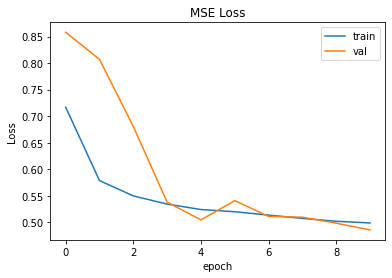

In [ ]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('MSE Loss')
plt.ylabel('Loss')
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/mse.jpg')
plt.show()

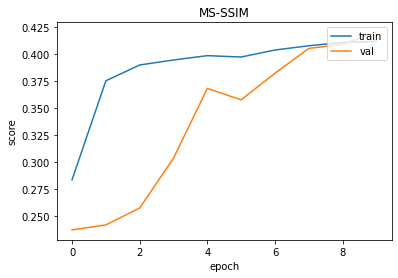

In [ ]:
plt.plot(hist2.history['custom2Loss'])
plt.plot(hist2.history['val_custom2Loss'])
plt.title('MS-SSIM')
plt.ylabel('score')
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/msssim.jpg')
plt.show()

In [ ]:
plt.plot(hist2.history['customIoU'])
plt.plot(hist2.history['val_customIoU'])
plt.title('Custom IoU')
plt.ylabel('score')
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/iou.jpg')
plt.show()

KeyError: ignored

## Infer model

In [15]:
### Load pretrained model to see IoU score
from keras.models import load_model
m2 = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/weights/weights_best_fast.hdf5", compile=False)
m2

In [25]:
m2.compile(metrics=['mse'])

In [26]:
m2.evaluate(test_ds)

20/20 [==============================] - 2s 85ms/step - loss: 0.0000e+00 - mse: 0.0074


[0.0, 0.007386040408164263]

In [ ]:
pred_ds2 = m2.predict(test_ds)
rec2 = pred_ds2[0]

#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/Reconstruction.png')

True

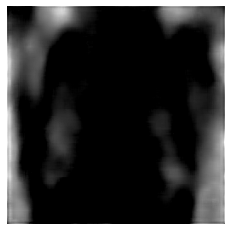

In [17]:
plt.imshow(rec2.reshape(256,256),'gray')
plt.axis('off')
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/Reconstruction.png',rec2.reshape(256,256)*255)

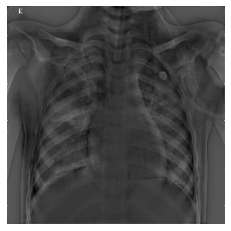

In [19]:
for batch in test_ds.take(1):
    #print(image[0].shape)
    image2 = batch[0][0]
    plt.imshow(image2.numpy().reshape(256,256),'gray')
    plt.axis('off')
    cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/True.png',image2.numpy().reshape(256,256)*255)

In [20]:
diff2 = image2 - rec2
np.mean(np.square(diff2.numpy()))


0.004789945

In [22]:
np.save('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/diff.npy',diff2)
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/Delta.png',diff2.numpy().reshape(256,256)*255)

True

In [ ]:
plt.imshow(diff2.numpy().reshape(256,256),'gray')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/Delta.png')

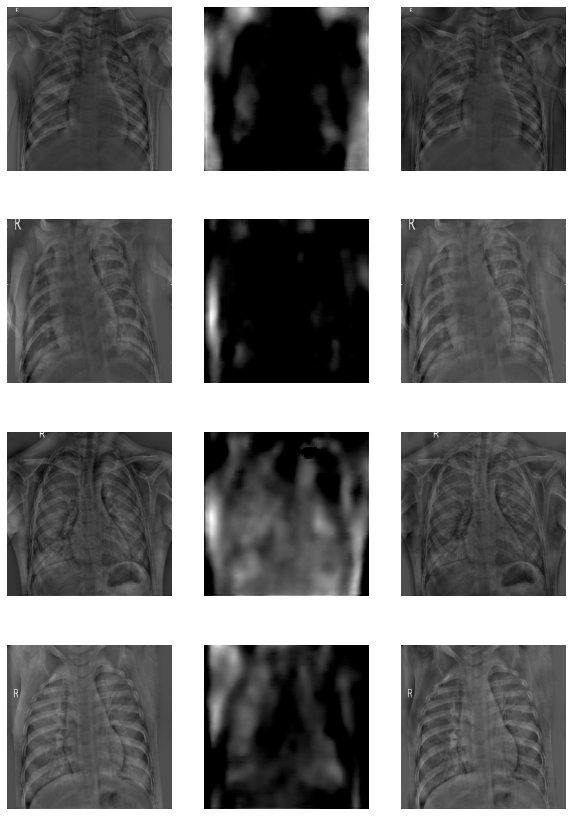

In [24]:
plt.figure(figsize=(10,15)) 
num_images_to_show = 4
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*3 + 1
    #rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 3, plot_ind)
    for batch in test_ds.take(1):
        image2 = batch[0][im_ind]
        plt.imshow(image2.numpy().reshape(256,256),'gray')
        plt.axis('off')
    rec2 = pred_ds2[im_ind]
    plt.subplot(num_images_to_show, 3, plot_ind+1)
    plt.imshow(rec2.reshape(256,256),'gray')
    plt.axis('off')
    plt.subplot(num_images_to_show, 3, plot_ind+2)
    diff2 = image2 - rec2
    plt.imshow(diff2.numpy().reshape(256,256),'gray')
    plt.axis('off')
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.5, 
#                     top=0.2, 
#                     wspace=0.5, 
#                     hspace=0.5)
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/summary.png')

In [ ]:
m2.predict(test_ds)

In [ ]:
from keras.models import load_model
dummy = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best.hdf5", compile=False)

from keras.models import Model
testen = Model(inputs = dummy.layers[1].input, outputs = dummy.layers[1].output)  
testde = Model(inputs = dummy.layers[2].input, outputs = dummy.layers[2].output)

In [ ]:
ae.evaluate(test_ds)

20/20 [==============================] - 73s 4s/step - loss: 0.0065


0.0065462626516819

In [ ]:
ae.predict?

In [ ]:
test_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 65536), dtype=tf.float32, name=None), TensorSpec(shape=(None, 65536), dtype=tf.float32, name=None))>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


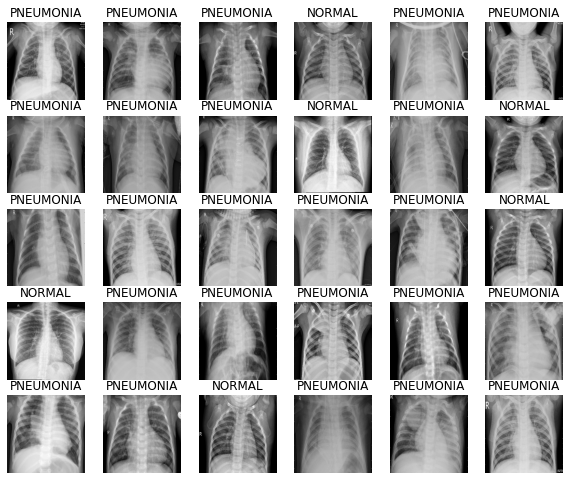

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().reshape(img_height,img_width),'gray')
        #plt.title(class_names[[tf.argmax(labels[i])]])
        plt.axis("off")

In [ ]:
batch[0][0]

<tf.Tensor: shape=(65536,), dtype=float32, numpy=
array([0.17245711, 0.19451594, 0.17938113, ..., 0.14117648, 0.1387255 ,
       0.13725491], dtype=float32)>

In [ ]:
diff = image - rec
np.mean(np.square(diff.numpy()))

0.004987583

In [ ]:
np.sqrt(0.00587*255*255)

19.537060935565513

# Load model

In [ ]:
from keras.models import load_model
m3 = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/weights/weights_best_fast.hdf5", compile=False)
# m3.compile(metrics=[customIoU])  #NO loss metric given to compile
# m3.evaluate(test_ds)                # CNN 1.0 MODEL LOADED

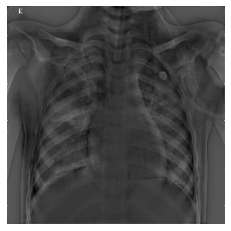

In [19]:
for batch in test_ds.take(1):
    #print(image[0].shape)
    image = batch[0][0]
    plt.imshow(image.numpy().reshape(256,256),'gray')
    plt.axis('off')
    #plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN3/True.png')

In [21]:
low = np.min(image.numpy())
hi = np.max(image.numpy())

image8 = (image.numpy() - low)/(hi - low)*255

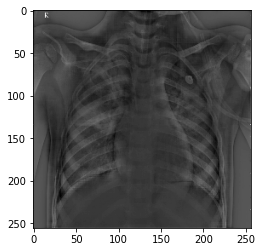

In [23]:
plt.imshow(image8.reshape(256,256),'gray')

In [25]:
cv2.imwrite("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/deltainput.png",image8.reshape(256,256))

True

In [26]:
np.save("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/deltainput.npy",image8.reshape(256,256))

In [30]:
rec = m3.predict(image.numpy().reshape(1,256,256,1))

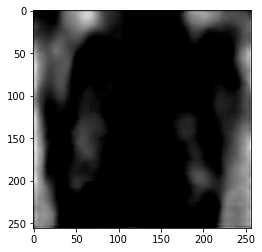

In [32]:
plt.imshow(rec.reshape(256,256),'gray')

In [33]:
rec = rec.reshape(256,256)

In [35]:
delta = image.numpy().reshape(256,256) - rec

In [39]:
lo = np.min(delta)
hi = np.max(delta)

delta8 = (delta - low)/(hi - lo)*255

In [41]:
np.save("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/delta.npy",delta8)

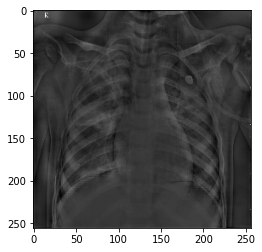

In [42]:
plt.imshow(delta8,'gray')

In [43]:
cv2.imwrite("/content/drive/MyDrive/Miniproject/chest_xray/CNN3/delta.png",delta8)

True